In [4]:
import warnings

import astropy.units
import FunctionLib as FL
import inspect
from tqdm import tqdm
import astropy
import wave
from matplotlib.image import resample
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import re
import scipy
import bagpipes

mpl.rcParams['font.family'] = 'serif'


warnings.filterwarnings("ignore")

DJAv4Catalog = FL.Spectrum_Catalog()
DJAv4Catalog.load_from_pkl(os.path.expanduser(
    '~/DustCurve/DJAv4Catalog.pkl'))
print(DJAv4Catalog.sample_num())

DJAv4Catalog.to_dataframe()

459


,survey_id_subid,survey_id,prism_filepath,prism_redshift,grating_filepaths,grating_redshifts,determined_redshift,file_count,available_filters,properties
0,snh0pe-v4_4446_102,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,0.2259,{'g235m-f170lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g235m-f170lp': nan, 'g140m-f100lp': nan}",0.2259,3,"{prism-clear, g140m-f100lp, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
1,snh0pe-v4_4446_143,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.6318,{'g235m-f170lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g235m-f170lp': 1.6309, 'g140m-f100lp': 1.6313}",1.6311,3,"{prism-clear, g140m-f100lp, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
2,snh0pe-v4_4446_285,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,0.4446,{'g235m-f170lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g235m-f170lp': 0.4462, 'g140m-f100lp': 0.4462}",0.4462,3,"{prism-clear, g140m-f100lp, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
3,snh0pe-v4_4446_29,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.7834,{'g235m-f170lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g235m-f170lp': 1.7796, 'g140m-f100lp': 1.7799}",1.77975,3,"{prism-clear, g140m-f100lp, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
4,snh0pe-v4_4446_123,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.7855,{'g235m-f170lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g235m-f170lp': 1.7851, 'g140m-f100lp': 1.7855}",1.7855,3,"{prism-clear, g140m-f100lp, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
...,...,...,...,...,...,...,...,...,...,...
32564,ceers-ddt-v4_2750_1636,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,3.0592,{},{},3.0592,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32565,ceers-ddt-v4_2750_3213,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,4.8013,{},{},4.8013,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32566,ceers-ddt-v4_2750_340,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,0.9585,{},{},0.9585,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32567,ceers-ddt-v4_2750_21413,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,2.1402,{},{},2.1402,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."


In [8]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum) // binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_vandels_spec(filepath):

    hdulist = astropy.io.fits.open(filepath)

    spectrum = np.c_[hdulist[1].data["wave"],
                     hdulist[1].data["flux"],
                     hdulist[1].data["err"]]

    return bin(spectrum, 2)

In [9]:
for id, catalog in DJAv4Catalog.catalog_iterator():
    if not catalog['properties']['Sample_Flag']:
        continue

    galaxy=bagpipes.galaxy(catalog['prism_filepath'],load_vandels_spec, photometry_exists=False)






    break

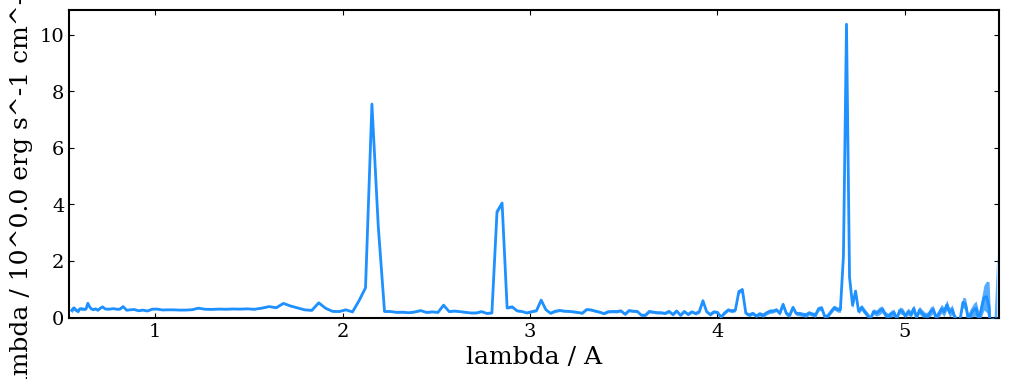

(<Figure size 1200x400 with 1 Axes>,
 [<Axes: xlabel='lambda / A', ylabel='f_lambda / 10^0.0 erg s^-1 cm^-2 A^-1'>])

In [10]:
galaxy.plot()